In [1]:
from utils.load_data import load_pt_results, load_behavioral_data
from utils.compare_parameters import t_test_ind
import seaborn as sns
import matplotlib.pyplot as plt
from modeling.prospect_theory import (calc_subjective_utility, 
                                      fit_pt_model,
                                      get_predicted_output,
                                      get_prob_accept)
import numpy as np
import pandas as pd

Prospect Theory has 3 free parameters: Lambda (loss aversion), rho (curvature), mu (temperature)
1. Model 1: All free parameters
2. Model 2: Mu = 100 (no temperature)
3. Model 3: Rho = 1 (no curvature)
4. Model 4: Lambda = 1 (no loss aversion)
5. Model 5: Only Loss aversion
6. Model 6: Only curvature
7. Model 7: Linear utility (no loss aversion or curvature)

In [4]:
pt_params = load_pt_results()
behavioral_data = load_behavioral_data(min_RT = 0.2)

([], [])

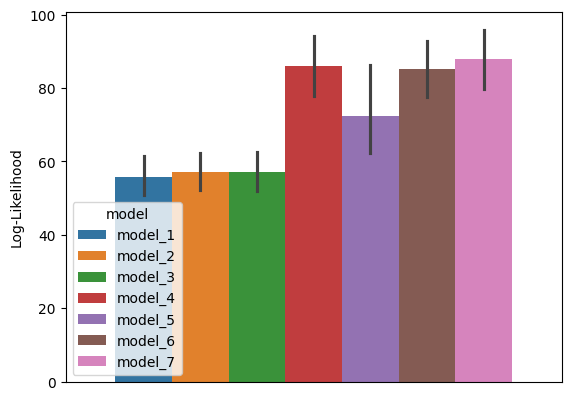

In [11]:
sns.barplot(pt_params.query("param_name == 'loss'"), x = 'param_name', y = 'param_value', hue = 'model')
plt.ylabel("Log-Likelihood")
plt.xlabel("")
plt.xticks([], [])

From left to right, goes from more free parameters to less free parameters. Lambda (loss aversion) is very important for the loss function. Since Model 2 and Model 3 have similar loss functions, we compare how well they did. 

In [12]:
# Check if one model performed better
t_test_ind(pt_params.query("param_name == 'loss'"), condition_name = "model", conditions = ["model_2", "model_3"])

No significant difference for loss
t_stats:  -0.017161450346293176 p_values:  0.9863238051052572



Since there is no significant increase in performance for model 1 and model 2, we use the simpler model (model 1). 

In [40]:
pt_params = load_pt_results()

pt_params = pt_params.query("model == 'model_3'")

Lets check the performance of the model:

### Previous stuff

We choose the simpler model (with mu = 1) since there isnt any difference between the loss function. 

#### Differences between condition

In [41]:
pt_params = pt_params.query("param_name == 'mu' | param_name == 'lambda'")

In [42]:
t_test_ind(pt_params, conditions = ["equalRange", "equalIndifference"])

Significant difference for lambda
t_stats:  -5.151498078480566 p_values:  3.6056727350451214e-06

No significant difference for mu
t_stats:  -0.6018316011664572 p_values:  0.8228569950280897



In [43]:
pt_params.groupby(["condition", "param_name"])["param_value"].mean()

condition          param_name
equalIndifference  lambda        1.599390
                   mu            2.669217
equalRange         lambda        1.113997
                   mu            1.853172
Name: param_value, dtype: float64

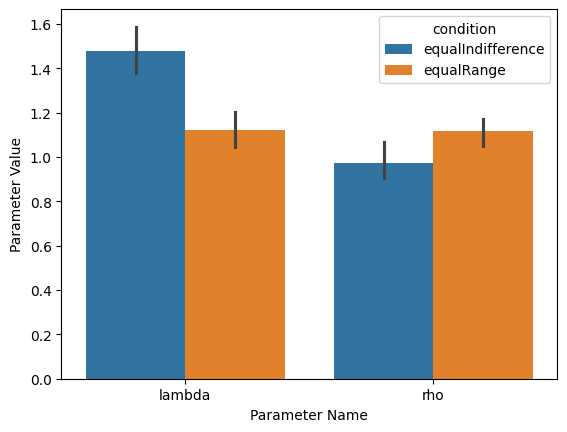

In [37]:
sns.barplot(pt_params, x = "param_name", y = "param_value", hue = "condition")
plt.xlabel("Parameter Name")
plt.ylabel("Parameter Value")
plt.show()

In [2]:
behavioral_data = load_behavioral_data(min_RT = 0.2)

equalRange = behavioral_data.query("condition == 'equalRange'")
equalRange = equalRange.groupby(["gain", "loss"])[["accept", "RT"]].mean().reset_index()
equalRange["sub"] = 1
equalIndifference = behavioral_data.query("condition == 'equalIndifference'")
equalIndifference = equalIndifference.groupby(["gain", "loss"])[["accept", "RT"]].mean().reset_index()
equalIndifference["sub"] = 2

In [3]:
pt_parameters = dict()
pt_parameters[1], lossRange = fit_pt_model(equalRange, bounds = ((0, None), (0, None), (0, None)))
pt_parameters[2], lossIndifference = fit_pt_model(equalIndifference, bounds = ((0, None), (0, None), (0, None)))
group_data = pd.concat([equalRange, equalIndifference])

In [ ]:
result = get_prob_accept(pt_parameters, group_data)

In [8]:
equalRange["pred_accept"] = result[1]
equalIndifference["pred_accept"] = result[2]
group_data = pd.concat([equalRange, equalIndifference])

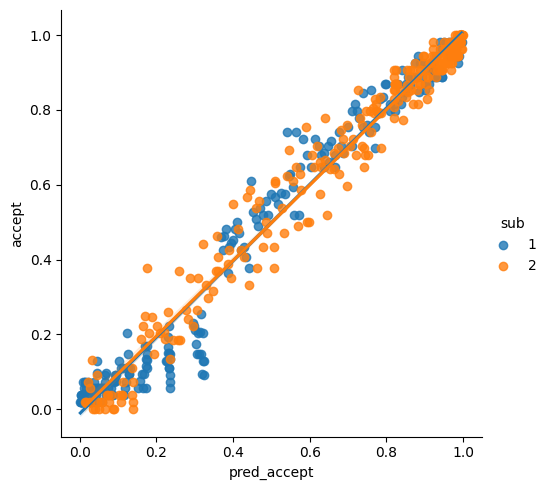

In [10]:
sns.lmplot(group_data, x = "pred_accept", y = "accept", hue = "sub")

In [29]:
# Use these two plots to compare behavior with the fits. 
equalIndifference["diff"] = np.log(equalIndifference["loss"] / equalIndifference["gain"])
equalRange["diff"] = np.log(equalRange["loss"] / equalRange["gain"])

In [36]:
from scipy.optimize import curve_fit

# Define the function
def sigmoid_like(x, alpha, beta):
    return 1 / (1 + alpha * np.exp(beta * x))

# Extract x and y from DataFrame
x_data = equalIndifference["diff"].values
y_data = equalIndifference["accept"].values

# Fit the function to the data
params, covariance = curve_fit(sigmoid_like, x_data, y_data, p0=[1, 1])  # Initial guess for alpha and beta

# Extract fitted parameters
alpha_fitIndiff, beta_fitIndiff = params
print(f"Fitted alpha: {alpha_fitIndiff}, Fitted beta: {beta_fitIndiff}")

# Extract x and y from DataFrame
x_data = equalRange["diff"].values
y_data = equalRange["accept"].values

# Fit the function to the data
params, covariance = curve_fit(sigmoid_like, x_data, y_data, p0=[1, 1])  # Initial guess for alpha and beta

# Extract fitted parameters
alpha_fitRange, beta_fitRange = params
print(f"Fitted alpha: {alpha_fitRange}, Fitted beta: {beta_fitRange}")

Fitted alpha: 4.979316811441883, Fitted beta: 4.150943120792188
Fitted alpha: 1.5732939613861652, Fitted beta: 5.927350931882368


Alpha tells us that at the x = 0 (which is when the gain and loss are the same), then the probability of acceptance is 1/(1+alpha). This, in a way I guess would be the bias of responding to accepting or rejecting. 
For low reward, it is 38.8% acceptance and for high reward its 16.7% acceptance. 
In general, gambles are rejected when they arent. 

The beta parameter is a gain parameter. Which is essentially, how much evidence one requires to shift your acceptance. Higher beta, less information you need cause you are more easily convinced basically.

In [52]:
i = 4
# Extract x and y from DataFrame
x_data = behavioral_data.query(f"sub == {i}")["diff"].values
y_data = behavioral_data.query(f"sub == {i}")["accept"].values

# Fit the function to the data
params, covariance = curve_fit(sigmoid_like, x_data, y_data, p0=[1, 10])  # Initial guess for alpha and beta

# Extract fitted parameters
alpha, beta = params
print(f"Fitted alpha: {alpha}, Fitted beta: {beta}")

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_53760/109989808.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + alpha * np.exp(beta * x))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

<module 'matplotlib.pyplot' from '/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

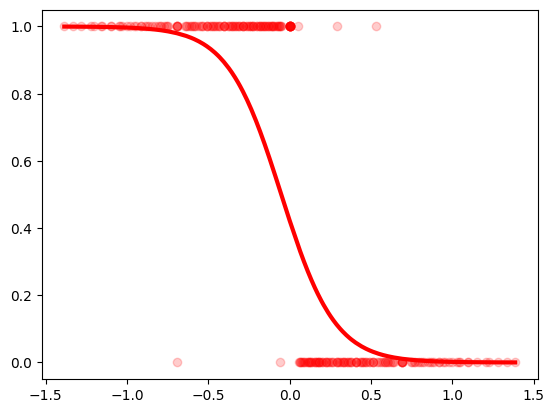

In [53]:
behavioral_data["diff"] = np.log(behavioral_data["loss"] / behavioral_data["gain"])
plt.scatter(behavioral_data.query(f"sub == {i}")["diff"], behavioral_data.query(f"sub == {i}")["accept"], alpha = 0.2, c = "red")
plt.plot(behavioral_data.query(f"sub == {i}")["diff"].sort_values(), sigmoid_like(behavioral_data.query(f"sub == {i}")["diff"].sort_values(), alpha, beta), c = "red", linewidth=3.0)
plt

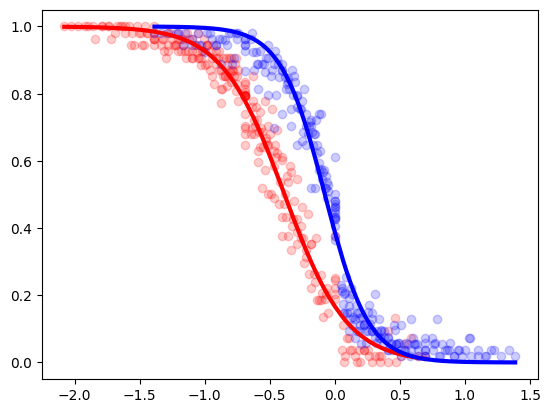

In [39]:
plt.scatter(equalIndifference["diff"], equalIndifference["accept"], alpha = 0.2, c = "red")
plt.scatter(equalRange["diff"], equalRange["accept"], alpha = 0.2, c = "blue")
plt.plot(equalIndifference["diff"].sort_values(), sigmoid_like(equalIndifference["diff"].sort_values(), alpha_fitIndiff, beta_fitIndiff), c = "red", linewidth=3.0)
plt.plot(equalRange["diff"].sort_values(), sigmoid_like(equalRange["diff"].sort_values(), alpha_fitRange, beta_fitRange), c = "blue", linewidth=3.0)
plt.show()

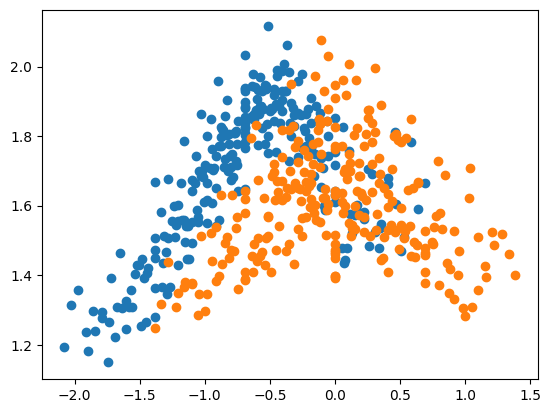

In [25]:
# equalIndifference["diff"] = equalIndifference["gain"] - equalIndifference["loss"]
# equalRange["diff"] = equalRange["gain"] - equalRange["loss"]
plt.scatter(equalIndifference["diff"], equalIndifference["RT"])
plt.scatter(equalRange["diff"], equalRange["RT"])
plt.show()

(-10.0, 10.0)

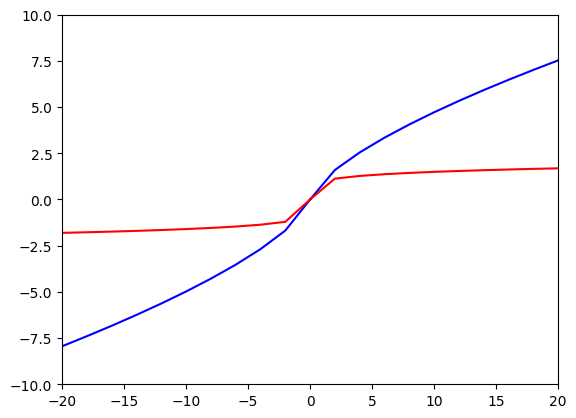

In [16]:
gains_equalRange, gains_equalIndifference = np.arange(0, 22, 2), np.arange(0, 42, 2)
losses = np.arange(0, -22, -2)
plt.plot(gains_equalRange, [calc_subjective_utility(g, pt_parameters[1][0], pt_parameters[1][1]) for g in gains_equalRange], c = 'blue')
plt.plot(gains_equalIndifference, [calc_subjective_utility(g, pt_parameters[2][0], pt_parameters[2][1]) for g in gains_equalIndifference], c = 'red')
plt.plot(losses, [calc_subjective_utility(g, pt_parameters[1][0], pt_parameters[1][1]) for g in losses], c = 'blue', label = 'equalRange')
plt.plot(losses, [calc_subjective_utility(g, pt_parameters[2][0], pt_parameters[2][1]) for g in losses], c = 'red', label = 'equalIndifference')
plt.xlim(-20, 20)
plt.ylim(-10, 10)

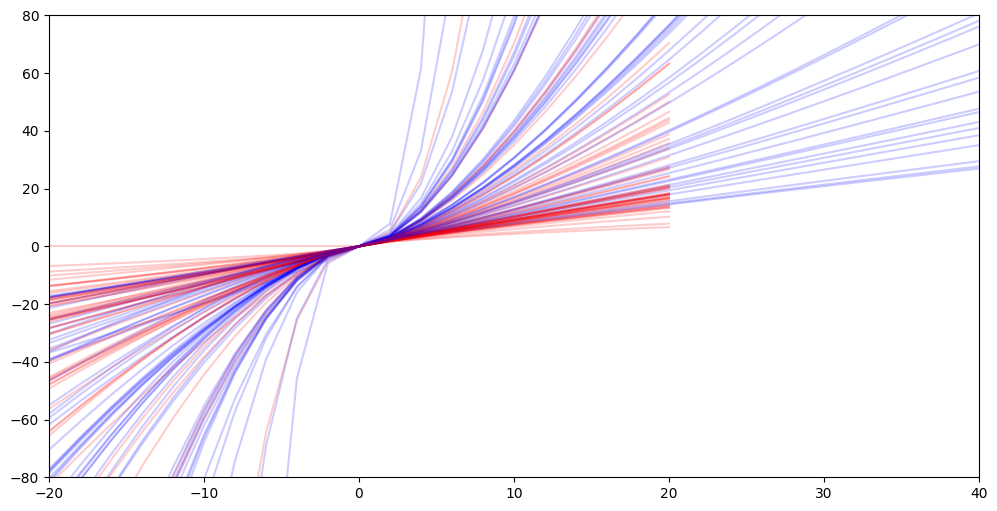

In [9]:
# Start a figure with ax
plt.figure(figsize=(12, 6))

gains_equalRange, gains_equalIndifference = np.arange(0, 22, 2), np.arange(0, 42, 2)
losses = np.arange(0, -22, -2)

for sub in pt_params["sub"].unique():
    sub_params = pt_params.query("sub == @sub")
    rho = sub_params.query("param_name == 'rho'")["param_value"].values[0]
    lam = sub_params.query("param_name == 'lambda'")["param_value"].values[0]
    if sub_params["condition"].values[0] == "equalRange":
        plt.plot(gains_equalRange, calc_subjective_utility(gains_equalRange, rho, lam), c = 'red', alpha = 0.2)
        plt.plot(losses, calc_subjective_utility(losses, rho, lam), c = 'red', alpha = 0.2)
    elif sub_params["condition"].values[0] == "equalIndifference":
        plt.plot(gains_equalIndifference, calc_subjective_utility(gains_equalIndifference, rho, lam), c = 'blue', alpha = 0.2)
        plt.plot(losses, calc_subjective_utility(losses, rho, lam), c = 'blue', alpha = 0.2)
plt.ylim(-80, 80)
plt.xlim(-20, 40)
plt.show()

In [49]:
gains_equalIndifference

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40])